# DBS decorrelates BG input to M1
### Supp Figure 1. Estimation of beta phase with waveform method
A. Voltage time series filtered in the beta band (13-30Hz) with zero crossings marked

B. Peaks identified by finding the timepoint of maximum voltage between a rising zerocrossing and a subsequent decay zerocross. Troughs found similarly in the other half-cycle.

C. Phase is interpolated using zerocrossings and extrema

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

**necessary functions**

In [2]:
from pacpy.pac import firf
from voytoys.shape.shape import wfpha, findpt

def zerox(x, frange, Fs = 1000.):

    # Filter in narrow band
    xn = firf(x, frange, Fs)
    xn = _edgeadd_paseries(xn,frange,Fs)
    
    # Initialize phase array
    L = len(xn)
    pha = np.empty(L)
    pha[:] = np.NAN
    
    # Find zero crosses
    def fzerofall(data):
        pos = data > 0
        return (pos[:-1] & ~pos[1:]).nonzero()[0]
        
    def fzerorise(data):
        pos = data < 0
        return (pos[:-1] & ~pos[1:]).nonzero()[0]
        
    zr = fzerorise(xn)
    zf = fzerofall(xn)
    
    return xn, zr, zf

def _edgeadd_paseries(amp, fosc, Fs, w = 3):
    """
    Undo the removal of edge artifacts done by pacpy in order to align
    the extrema with their amplitudes
    """
    Ntaps = np.floor(w * Fs / fosc[0])
    amp2 = np.zeros(len(amp)+2*Ntaps)
    amp2[Ntaps:-Ntaps] = amp
    return amp2

**Load recording**

In [6]:
v = np.load('./temp.npy') # DBS setting to plot: before DBS
dt = .001
Fs = 1/dt
t = np.arange(0,len(v)*dt,dt)
t_plot = (3,4) # Time range to plot (seconds)

# Samples to plot
sampsT = np.arange(len(t))
samps = sampsT[np.logical_and(t>=t_plot[0], t<t_plot[1])]

In [7]:
fbeta = (13,30)
vbeta, zxr, zxf = zerox(v, fbeta, Fs)
zxrp = zxr[np.logical_and(zxr>=t_plot[0]*Fs, zxr<t_plot[1]*Fs)]
zxfp = zxf[np.logical_and(zxf>=t_plot[0]*Fs, zxf<t_plot[1]*Fs)]

peaksW, troughsW = findpt(v, fbeta, Fs = Fs, )
peaksWp = peaksW[np.logical_and(peaksW>=t_plot[0]*Fs, peaksW<t_plot[1]*Fs)]
troughsWp = troughsW[np.logical_and(troughsW>=t_plot[0]*Fs, troughsW<t_plot[1]*Fs)]

bphaW = wfpha(v, peaksW, troughsW)

from pacpy.pac import pa_series
flo = (13,30) # Beta band (Hz)
fhi = (80,200) # Gamma band (Hz)
bphaH, gamp = pa_series(v, v, flo, fhi)
bphaH = _edgeadd_paseries(bphaH, flo, Fs)

C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


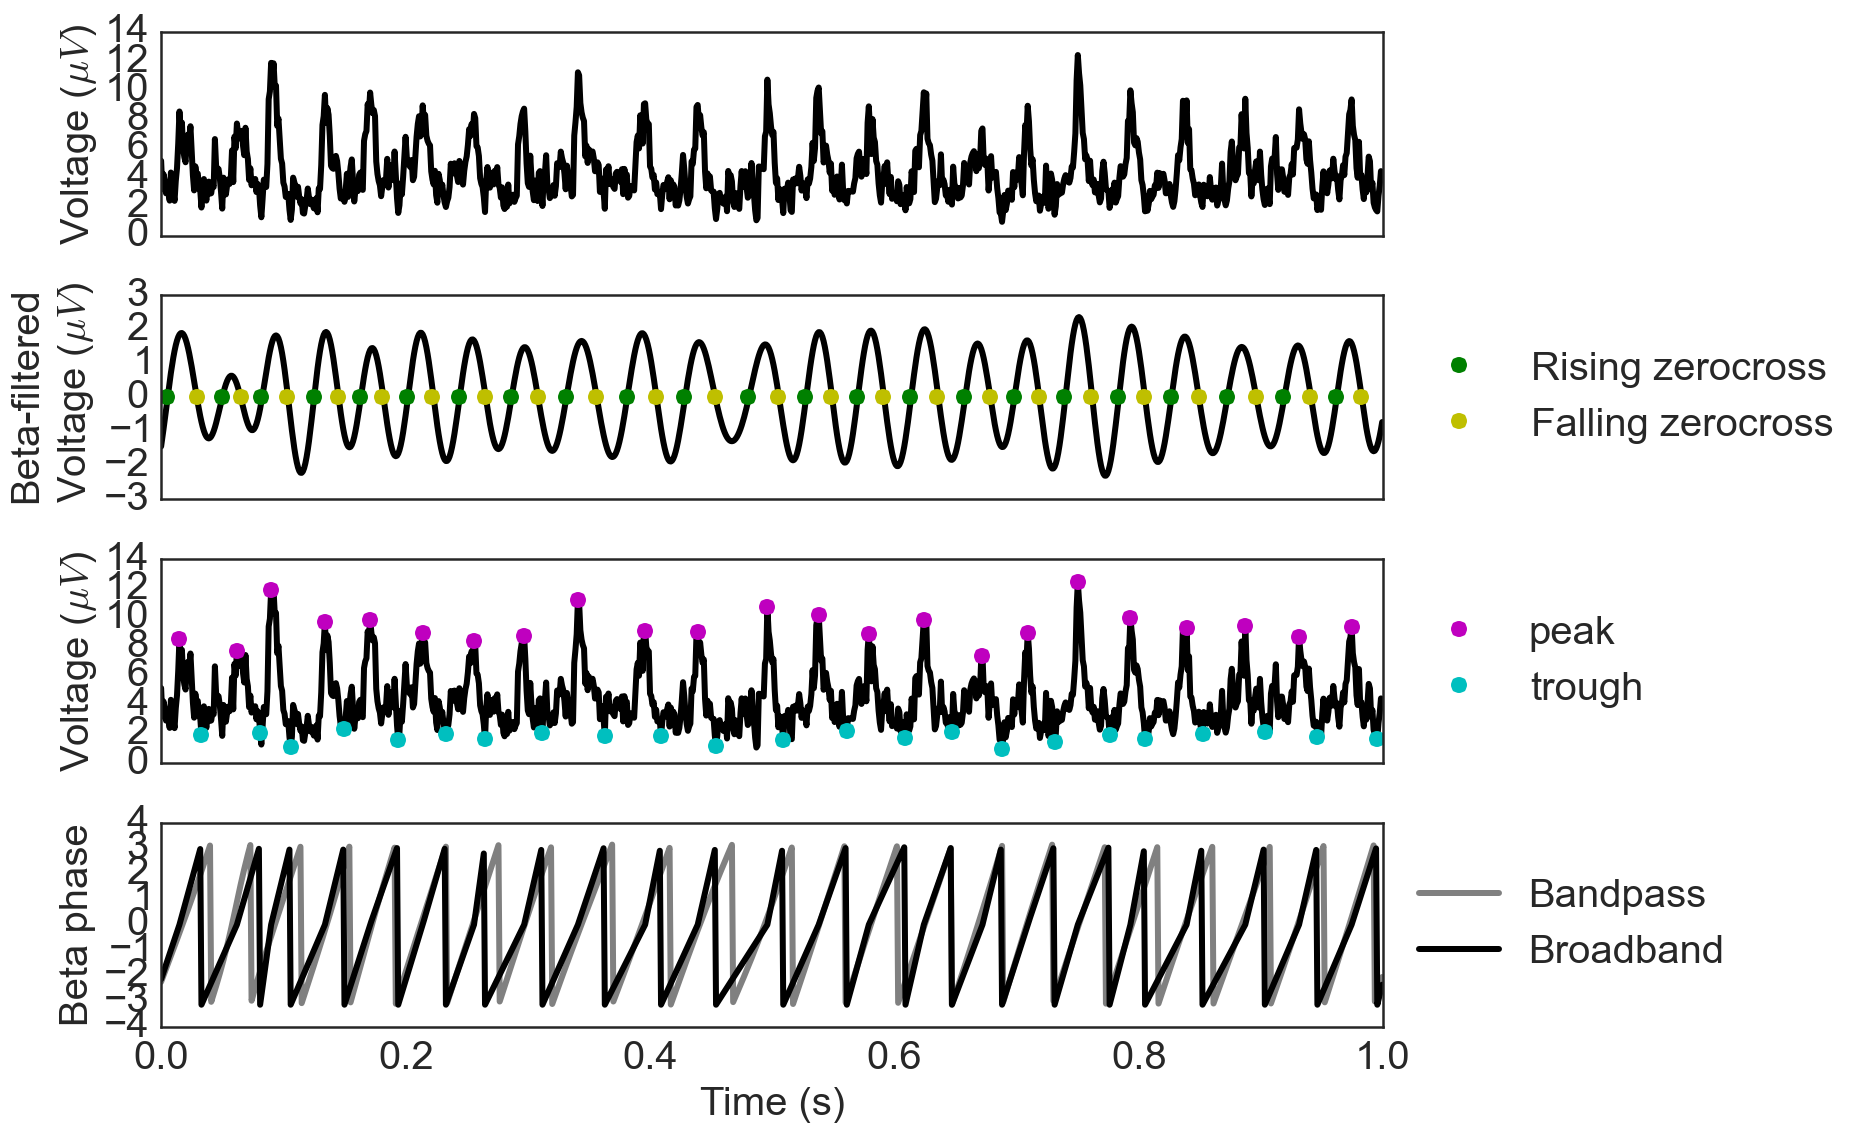

In [9]:
fig = plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.plot(t[samps]-t[samps[0]], v[samps],'k',linewidth=3)
plt.ylabel('Voltage ($\mu V$)',size=20)
#plt.ylim((-300,700))
#plt.yticks([-300,0,700])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,2)
plt.plot(t[samps]-t[samps[0]], vbeta[samps], 'k',linewidth=3)
plt.plot(t[zxrp] - t[samps[0]], np.zeros(len(zxrp)), 'go', ms=8,label='Rising zerocross')
plt.plot(t[zxfp] - t[samps[0]], np.zeros(len(zxfp)), 'yo', ms=8,label='Falling zerocross')
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.ylabel('Beta-filtered\n Voltage ($\mu V$)',size=20)
#plt.ylim((-400,400))
#plt.yticks([-400,0,400])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,3)
plt.plot(t[samps]-t[samps[0]], v[samps], 'k-',linewidth=3)
plt.plot(t[peaksWp]-t[samps[0]],v[peaksWp],'mo', ms=8, label='peak')
plt.plot(t[troughsWp]-t[samps[0]],v[troughsWp],'co', ms=8, label='trough')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.ylabel('Voltage ($\mu V$)',size=20)
#plt.ylim((-300,700))
#plt.yticks([-300,0,700])
plt.tick_params(labelsize=20)
plt.setp( plt.gca().get_xticklabels(), visible=False)

plt.subplot(4,1,4)
plt.plot(t[samps]-t[samps[0]], bphaH[samps], color='0.5',linewidth=3, label='Bandpass')
plt.plot(t[samps]-t[samps[0]], bphaW[samps], 'k',linewidth=3, label='Broadband')
plt.ylabel('Beta phase',size=20)
plt.xlabel('Time (s)',size=20)
#plt.ylim([-4,4])
#plt.yticks([-np.pi,0,np.pi],['$-\pi$','0','$\pi$'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tick_params(labelsize=20)
plt.tight_layout()